# Import packages

In [30]:
## Generic packages that are on your operating system
import glob
import os
import time

## Additional required packages
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

## Important scikit-learn packages for fitting logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import SplineTransformer, PolynomialFeatures
from sklearn.calibration import calibration_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


## Required definitions and constants

In [3]:
files = glob.glob('datasets/IMERG*_Nairobi.zarr')
ds_IMERG = xr.open_mfdataset(files,engine="zarr")

latitude_IMERG = ds_IMERG.latitude.values
longitude_IMERG = ds_IMERG.longitude.values

box_left = longitude_IMERG-0.05
box_right = longitude_IMERG+0.05
box_down = latitude_IMERG-0.05
box_up = latitude_IMERG+0.05


def bounding_box(region,points,min_x=box_left,max_x=box_right,min_y=box_down,max_y=box_up):

    """
    points: latitude, longitude
    x: longitude
    y: latitude
    """

    section_x = []
    section_y = []
    
    for x_min, x_max in zip(box_left,box_right):
        if region == 'J.K.I.A.':
            section_x.append(np.logical_and(points[1]<=x_max+0.01,points[1]>=x_min-0.01))
        else:
            section_x.append(np.logical_and(points[1]<=x_max,points[1]>=x_min))
            
    for y_min, y_max in zip(box_down,box_up):    
        section_y.append(np.logical_and(points[0]<=y_max,points[0]>=y_min))

    idx = np.squeeze(np.argwhere(np.logical_and(np.array(section_x),np.array(section_y))))

    return idx

# Load in data

In [4]:
files = glob.glob('datasets/cGAN_50*_Nairobi.zarr')
ds_cGAN_50 = []
for file in files:
    ds_temp = xr.open_dataset(file,engine="zarr")
    if type(ds_temp['time'].values[0]) == np.float32:
        ds_temp['time'] = (ds_temp['time'].astype('datetime64[ns]')+np.timedelta64(1,'h')).astype('datetime64[D]').astype('datetime64[ns]')
    ds_cGAN_50.append(ds_temp) 
ds_cGAN_50 = xr.concat(ds_cGAN_50, 'time').sortby('time')

files = glob.glob('datasets/cGAN_2*_Nairobi.zarr')
ds_cGAN = []
for file in files:
    ds_temp = xr.open_dataset(file,engine="zarr")
    if type(ds_temp['time'].values[0]) == np.float32:
        ds_temp['time'] = (ds_temp['time'].astype('datetime64[ns]')+np.timedelta64(1,'h')).astype('datetime64[D]').astype('datetime64[ns]')
    ds_cGAN.append(ds_temp) 
ds_cGAN = xr.concat(ds_cGAN, 'time').sortby('time')

files = glob.glob('datasets/IFS*_Nairobi.zarr')
ds_IFS = []
for file in files:
    ds_IFS.append(xr.open_zarr(file).drop_duplicates('time',keep='last'))

ds_IFS = xr.concat(ds_IFS,'time')

meta = pd.read_excel('SEWAA-data.xlsx',sheet_name='Gridded',index_col=0,nrows=2)
data = pd.read_excel('SEWAA-data.xlsx',sheet_name='Gridded',index_col=0,skiprows=[1,2])

ds = data.to_xarray().rename({'ID':'time'})

# Not sure if this is the best way but it works
ds['time'] = np.array([t[:4]+'-'+t[4:6]+'-'+t[-2:] for t in ds['time'].values.astype(str)],dtype='datetime64[ns]')


/var/folders/z9/7vk0kbx55g91_3mr8vw6gt_80000gp/T/ipykernel_37101/3265667171.py:6: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds_temp['time'] = (ds_temp['time'].astype('datetime64[ns]')+np.timedelta64(1,'h')).astype('datetime64[D]').astype('datetime64[ns]')
/var/folders/z9/7vk0kbx55g91_3mr8vw6gt_80000gp/T/ipykernel_37101/3265667171.py:15: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This w

In [5]:
ds_IFS

<xarray.Dataset> Size: 4MB
Dimensions:    (time: 1571, member: 50, latlon: 6)
Coordinates:
    latitude   (latlon) float64 48B -1.35 -1.25 -1.35 -1.25 -1.25 -1.25
  * latlon     (latlon) int64 48B 0 1 2 3 4 5
    longitude  (latlon) float64 48B -1.35 -1.25 -1.35 -1.25 -1.25 -1.25
  * member     (member) int64 400B 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
  * time       (time) datetime64[ns] 13kB 2024-03-01 2024-03-02 ... 2021-12-31
Data variables:
    Nairobi    (time, member, latlon) float64 4MB dask.array<chunksize=(29, 50, 6), meta=np.ndarray>

In [9]:
## Make train dataset
train_years = [2018,2019,2020]
train_data_x = {}

train_data_x['cGAN'] = ds_cGAN.sel(time=ds_cGAN.time.dt.year.isin(train_years))
train_data_x['cGAN_50'] = ds_cGAN_50.sel(time=ds_cGAN_50.time.dt.year.isin(train_years))
train_data_x['IFS'] = ds_IFS.sel(time=ds_IFS.time.dt.year.isin(train_years))

train_valid_times = np.intersect1d(train_data_x['cGAN'].time.values + np.timedelta64(1,'D'),
                                   ds.time.values)
train_data_x['cGAN'] = train_data_x['cGAN'].sel({'time':train_valid_times - np.timedelta64(1,'D')})
train_data_x['cGAN_50'] = train_data_x['cGAN_50'].sel({'time':train_valid_times - np.timedelta64(1,'D')})
train_data_x['IFS'] = train_data_x['IFS'].sel({'time':train_valid_times - np.timedelta64(1,'D')})

train_data_y = ds.sel({'time':train_valid_times})

## Make validation dataset
val_years = [2021]
val_data_x = {}

val_data_x['cGAN'] = ds_cGAN.sel(time=ds_cGAN.time.dt.year.isin(val_years))
val_data_x['cGAN_50'] = ds_cGAN.sel(time=ds_cGAN_50.time.dt.year.isin(val_years))
val_data_x['IFS'] = ds_IFS.sel(time=ds_IFS.time.dt.year.isin(val_years))

val_valid_times = np.intersect1d(val_data_x['cGAN'].time.values + np.timedelta64(1,'D'),
                                   ds.time.values)
val_data_x['cGAN'] = val_data_x['cGAN'].sel({'time':val_valid_times - np.timedelta64(1,'D')})
val_data_x['cGAN_50'] = val_data_x['cGAN_50'].sel({'time':val_valid_times - np.timedelta64(1,'D')})
val_data_x['IFS'] = val_data_x['IFS'].sel({'time':val_valid_times - np.timedelta64(1,'D')})

val_data_y = ds.sel({'time':val_valid_times})

val_data_y

<xarray.Dataset> Size: 20kB
Dimensions:    (time: 352)
Coordinates:
  * time       (time) datetime64[ns] 3kB 2021-01-02 2021-01-03 ... 2021-12-30
Data variables:
    KABETE     (time) float64 3kB 0.584 0.313 0.019 0.047 ... 0.82 0.194 0.015
    EASTLEIGH  (time) float64 3kB 0.0 0.0 0.0 0.0 0.0 ... 0.418 0.208 0.0 0.0
    J.K.I.A.   (time) float64 3kB 0.0 0.0 0.0 0.0 0.0 ... 0.864 0.653 0.0 0.0
    DAGORETTI  (time) float64 3kB 1.866 1.573 0.042 0.215 ... 1.485 0.959 0.228
    NGONG      (time) float64 3kB 1.467 1.924 0.0 0.169 ... 0.0 0.007 0.0 0.0
    WILSON     (time) float64 3kB 0.0 0.0 0.0 0.0 0.0 ... 0.225 0.387 0.0 0.0

# Fit model for region

In [22]:
model = 'cGAN'
region = 'KABETE'
n_knots = 15
degree = 1
polyfeatures = 1

idx_region =  bounding_box(region,meta[region].values,min_x=box_left,max_x=box_right,min_y=box_down,max_y=box_up)

train_data_y_region = train_data_y[region].values
train_data_x_region = train_data_x[model].isel({'latlon':idx_region}).Nairobi.values

if train_data_x_region.shape[1]==1000:
    train_data_x_region = np.percentile(train_data_x_region,np.linspace(1,100,50),axis=1,method='weibull').T

# Manually make pipeline in future can use from sklearn.pipeline import make_pipeline
spline = SplineTransformer(n_knots=n_knots, degree=degree, knots='uniform',extrapolation='linear').fit(train_data_x_region)
polyfeatures = PolynomialFeatures(polyfeatures, interaction_only=True).fit(spline.transform(train_data_x_region))

transformed_x_region = polyfeatures.transform(spline.transform(train_data_x_region))

logreg = LogisticRegression(penalty='elasticnet',
                            l1_ratio=0.6,solver='saga',max_iter=100_000).fit(transformed_x_region,
                                                                             np.searchsorted([5,20,40],train_data_y_region))


In [23]:
## Define the bin for which we plot the calibraiton curve (i.e., 0, 1, 2, 3 for <5, 5-20, 20-50 and >50 respectively)
bin_to_plot = 3

## We get the true probabilities of occurrence for this bin as is in our y-vales
## we use np.where for this, see documentation here: https://numpy.org/doc/stable/reference/generated/numpy.where.html
actual_probabilities = np.where(np.searchsorted([5,20,40],train_data_y_region)==bin_to_plot,1,0)

## Now we get the predicted probabilities from the fitted models using the function predict_proba and
## The output of predict proba is of the shape (n_samples, n_bins) and we select our bin (i.e., [:,bin_to_plot] of interest
pred_probabilities = logreg.predict_proba(transformed_x_region)[:,bin_to_plot]#polyfeatures.transform(spline.transform(train_data_x_region))




Text(0, 0.5, 'Fraction of Positives [-]')

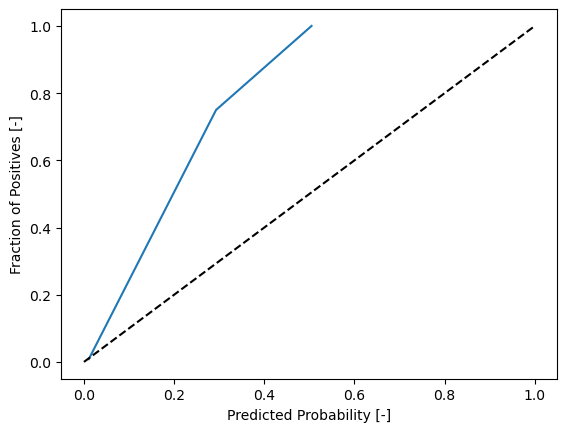

In [24]:
fraction_of_positives, predicted_prob = calibration_curve(actual_probabilities, pred_probabilities, n_bins=5)

plt.plot(predicted_prob, fraction_of_positives)
plt.plot([0,1],[0,1], color="black", linestyle="dashed")

plt.xlabel("Predicted Probability [-]")
plt.ylabel("Fraction of Positives [-]")


# Looping through regions for GridSearchCV

In [32]:
model = 'IFS'
thresholds = [5,20,40]
gridsearch_results = {}

model_pipeline = Pipeline(steps=[('spline', SplineTransformer(n_knots=5, degree=1, knots='uniform',extrapolation='linear')),
                                ('polyfeat', PolynomialFeatures(1, interaction_only=True)),
                                ('logreg', LogisticRegression(penalty='elasticnet',
                            l1_ratio=0.6,solver='saga',max_iter=100_000))])
cv = 3
param_grid = {'spline__n_knots':np.arange(5,16,5),'logreg__l1_ratio':np.arange(0.2,1,0.3)}
gridsearch = GridSearchCV(model_pipeline, param_grid, cv=5, n_jobs=4, scoring='neg_log_loss',verbose=True)

for region in ['KABETE']:#,'EASTLEIGH','J.K.I.A.','WILSON','DAGORETTI'

    idx_region =  bounding_box(region,meta[region].values,min_x=box_left,max_x=box_right,min_y=box_down,max_y=box_up)
    
    train_data_y_region = train_data_y[region].values
    train_data_x_region = train_data_x[model].isel({'latlon':idx_region}).Nairobi.values
    
    if train_data_x_region.shape[1]==1000:
        train_data_x_region = np.percentile(train_data_x_region,np.linspace(1,100,100),axis=1,method='weibull').T

    gridsearch_results[region] = gridsearch.fit(train_data_x_region, np.searchsorted(thresholds,train_data_y_region))

    

    

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [33]:
gridsearch_results[region].best_params_

{'logreg__l1_ratio': np.float64(0.8), 'spline__n_knots': np.int64(10)}

In [ ]:
model = 'cGAN'
region = 'KABETE'


idx_region =  bounding_box(region,meta[region].values,min_x=box_left,max_x=box_right,min_y=box_down,max_y=box_up)

val_data_y_region = val_data_y[region].values
val_data_x_region = val_data_x[model].isel({'latlon':idx_region}).Nairobi.values

if train_data_x_region.shape[1]==1000:
    train_data_x_region = np.percentile(train_data_x_region,np.linspace(1,100,100),axis=1,method='weibull').T



## Define the bin for which we plot the calibraiton curve (i.e., 0, 1, 2, 3 for <5, 5-20, 20-50 and >50 respectively)
bin_to_plot = 3

## We get the true probabilities of occurrence for this bin as is in our y-vales
## we use np.where for this, see documentation here: https://numpy.org/doc/stable/reference/generated/numpy.where.html
actual_probabilities = np.where(np.searchsorted([5,20,40],val_data_y_region)==bin_to_plot,1,0)

## Now we get the predicted probabilities from the fitted models using the function predict_proba and
## The output of predict proba is of the shape (n_samples, n_bins) and we select our bin (i.e., [:,bin_to_plot] of interest
pred_probabilities = logreg.predict_proba(transformed_x_region)[:,bin_to_plot]#polyfeatures.transform(spline.transform(train_data_x_region))

